# Simulation attempt of PDE from Fournier, 2007

This notebook covers the current attempts at simulating the PDE from Fournier 2007 "*A case for variational geomagnetic data assimilation: insights from a one-dimensional, nonlinear, and sparsely observed MHD system*". The spatial derivatives are computed using Chebyshev Differential Matrices as covered by Trefethen, e.g. in *Spectral Methods in Matlab*. The Matlab implementations have been translated to Python for this purpose.

The Time-stepping scheme is still unresolved, but an attempt with RK-4 is shown in this notebook.

Author: Rasmus C. Jørgensen, s164044

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt

# Utilities functions for plotting
def CreateCrossAxis(ax):
    # Move axes to the middle like a classic hand drawn coordinate system. This matches layout of
    # Fournier 2007. Source: https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    

### PDE
The PDE in question is covered in equations 16-20 in Fournier, 2007. Where *u* is the velocity field and *b* is the magnetic field. $\partial_x$ is used to indicate a spatial derivative wrt. x, likewise $\partial_t$ is a temporal derivative. The system is described as:

$\forall(x,t) \in ]-1,1[\times[0,T],$ 

$\partial_t u + S u \partial_x u = S b \partial _x b + Pm \partial_x^2 u,$

$\partial_t b + S u\partial_x b = S b \partial_x u + \partial_x ^2 b$

With initial conditions:

$u(x = \pm 1,t) = 0$

$b(x= \pm 1, t) = \pm 1$

Using same coefficients as Fournier, 2007, gives us:

$Pm = 10^{-3}$

$S = 1$

And the initial fields for *b* and *u* are given by the functions:

$u^t(x,t=0) = \sin(\pi x) + (2/5) \sin(5\pi x),$

$b^t(x,t=0) = \cos(\pi x) + 2\sin[\pi(x+1)/4]$

Where the superscript *t* indicates we're dealing with the true state of the system.

### Defining the PDE
We can define a function describing this PDE as shown below. In standard python notation, the dimensions of the input is expected to be : (2, N) 

Where N is equal to the spatial resolution, or in other words, the degree of the Chebyshev polynomial, which we'll implement in a second.

The output is similar also of dimensions (2,N).

This is a stack of the two fields *u* and *b* which we can unpack and use as desired.

Additionally, we rewrite the governing equations, gathering the time derivatives on the left-hand side, which gives us:

$\partial_t u = S b \partial _x b + Pm \partial_x^2 u - S u \partial_x u,$

$\partial_t b = S b \partial_x u + \partial_x ^2b - S u\partial_x b$

In [2]:
def PDE(ub):
    # Unpack field values
    u = ub[0]
    b = ub[1]

    # Compute spatial derivatives of u
    dux = Du@u
    ddux = D2u@u
    # Compute spatial derivatives of b
    dbx = Db@b
    ddbx = D2b@b
    # Compute the governing equations
    dut = S*b*dbx + Pm*ddux - S*u*dux
    dbt = S*b*dux + ddbx - S*u*dbx
    # Enforce boundary values as described by Trefethen
    # u-field boundary conditions
    dut[0] = 0
    dut[-1] = 0
    # b-field boundary conditions
    dbt[0] = 1
    dbt[-1] = -1
    # Return a stack of the two computed fields
    return np.stack([dut, dbt])

### Chebyshev implementation
Let us move on to define the Chebyshev function. This is based on the "cheb.m" implementation by Trefethen from *Spectral Methods in Matlab*. This takes N as input, which is equal to the spatial resolution of the system, and outputs [D, x], which is the chebyshev differential matrix D, and the Chebyshev points, x.

In [3]:
def cheb(N):
    if N == 0:
        D = 0
        x = 1
    else:
        # Construct help array
        zeroToN = np.arange(0,N+1)
        x = np.cos(np.pi* zeroToN/N).reshape(-1,1)
        # Placeholder c vector
        c_tmp = np.ones(N+1)
        c_tmp[0] = 2
        c_tmp[-1] = 2
        # True c
        c = (c_tmp * (-1) ** zeroToN).reshape(-1,1)
        X = np.tile(x, N+1)
        dX = X-X.T
        D = (c*(1/c).T) / (dX + np.eye(N+1)) # off-diagonal entires
        D = D - np.diag(sum(D.T)) # diagonal entries
    return D,x

We wish to test that this behaves as expected. Trefethen presents a variety of different programs to test his implementation, but we will just use 2 of them to cover the essentials. First Program 11, which is a simple first derivative of the function:

$u(x) = e^x\sin(5x)$
Which will be solved with N = 10, and N = 20.


All the original Matlab solutions can be found on: https://people.maths.ox.ac.uk/trefethen/spectral.html

But we'll just include the matlab solution to this specific solution as a figure here:

![P11_Matlab](Figures/p11_matlab.png "Title")

Solving it in Python using the cheb function above yields us:

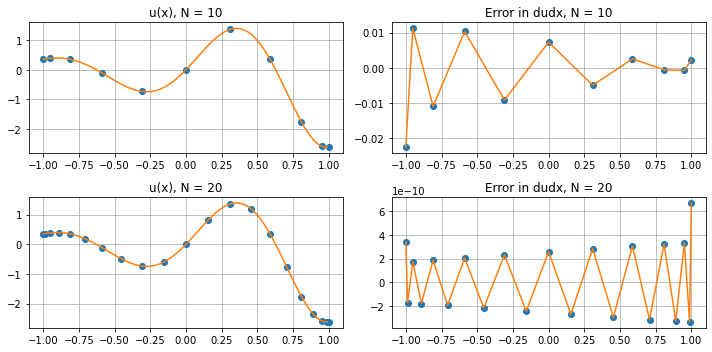

In [4]:
xx = np.arange(-1, 1, 0.01)
uu = np.exp(xx)*np.sin(5*xx)

fig, axes = plt.subplots(2,2, figsize=(10,5))
N = [10, 10, 20, 20]

for i, ax in enumerate(axes.flatten()):
    [D,x] = cheb(N[i])
    u = np.exp(x)*np.sin(5*x)
    if i % 2 == 0:
        ax.plot(x,u,'.', markersize=12)
        ax.plot(xx,uu,'-')
        ax.grid()
        ax.set_title('u(x), N = %i' %N[i])
    else:
        error = D@u - np.exp(x)*(np.sin(5*x)+5*np.cos(5*x))
        ax.plot(x,error,'.', markersize=12)
        ax.plot(x,error,'-')
        ax.grid()
        ax.set_title('Error in dudx, N = %i' %N[i])
fig.tight_layout()

Next up we'll attempt to solve program 32, which aims to solve a problem using the second derivative with boundary conditions. This is described as:

$u_{xx} = e^{4x}, \,\,\,\, -1 < x < 1,\,\,\,\, u(-1) = 0,\,\,\,\, u(1) = 1$

With the Matlab solution from Trefethen:
![P32_Matlab](Figures/p32_matlab.png "Title")

And the python solution from our implementation:

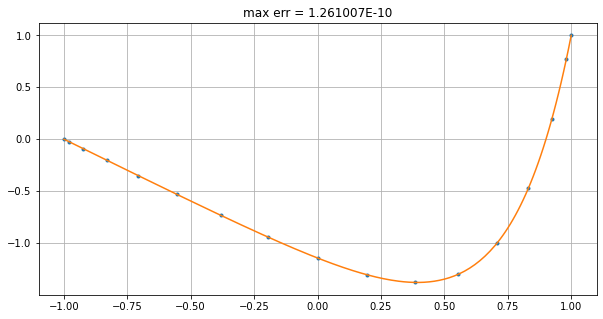

In [5]:
N = 16
[D, x] = cheb(N)
D2 = np.linalg.matrix_power(D, 2)
D2 = D2[1:N, 1:N]
f = np.exp(4*x[1:N])
u = np.linalg.solve(D2, f)
u = np.concatenate(([0], u.squeeze(), [0])).reshape(-1,1) + (x+1)/2

plt.figure(figsize=(10,5))
plt.plot(x,u,'.')
xx = np.arange(-1, 1.01, 0.01)
uu = np.polyval(np.polyfit(x.squeeze(), u, N), xx)
plt.plot(xx, uu, '-')
plt.grid()
exact = (np.exp(4*xx) - np.sinh(4)*xx - np.cosh(4)) / 16 + (xx+1)/2
plt.title('max err = %E' % (np.linalg.norm(uu-exact, np.inf)))
plt.show()

Confident that the cheb function works as intended, we'll move on to computing the derivatives of the initial *u* and *b* fields, $u^t(x,t=0)$ and $b^t(x,t=0)$. These have the analytic solutions of:

$\partial_x u = \pi[\cos(\pi x) + 2 \cos(\pi 5 x)]$

$\partial_{xx} u = -\pi^2[\sin(\pi x)+ 10 \sin(\pi 5 x)]$

$\partial_x b = \frac{1}{2} \pi [\cos(\frac{1}{4} \pi(x+1)) - 2 \sin(\pi x)]$

$\partial_{xx} b = -\frac{1}{8} \pi^2 [\sin(\frac{1}{4} \pi (1+x)) + 8 \cos(\pi x)]$

We can plot these along with the solution from the Chebyshev differential matrix, to try and ensure that our spatial derivatives are well behaved, as seen below.

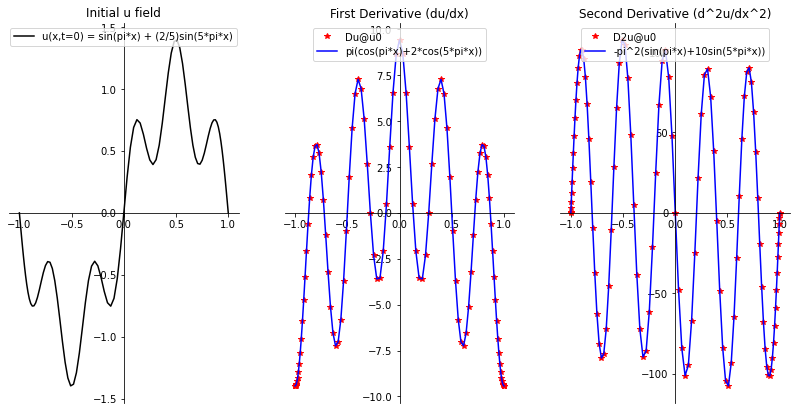

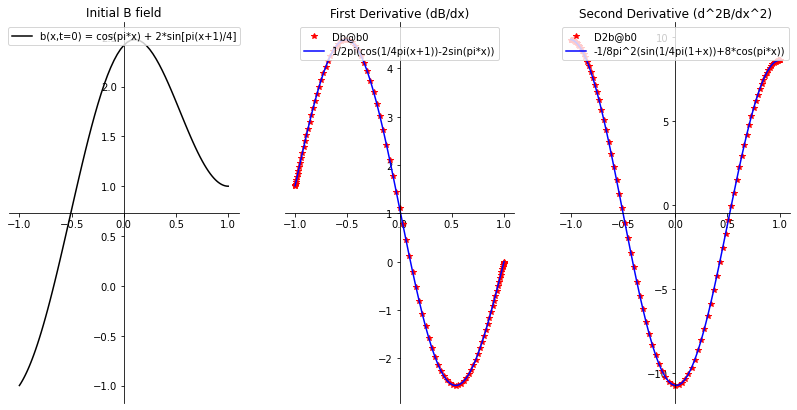

In [6]:
# Spatial resolution
N = 100
# Cheb matrix and points
D, x = cheb(N)
D2 = np.linalg.matrix_power(D, 2)

# True state of u_0 and b_0
u0 = np.sin(np.pi*x.squeeze()) + (2/5)*np.sin(5*np.pi*x.squeeze())
b0 = np.cos(np.pi*x.squeeze()) + 2*np.sin(np.pi*(x.squeeze() + 1)/4)


# Analytic solution, u
dudx_Analytic = np.pi*(np.cos(np.pi*x) + 2*np.cos(5*np.pi*x))
d2udx_Analytic = -np.pi**2 * (np.sin(np.pi*x) + 10*np.sin(5*np.pi*x))

# Analytic solution, b
dbdx_Analytic = 0.5*np.pi*(np.cos(0.25*np.pi*(x+1))-2*np.sin(np.pi*x))
d2bdx_Analytic = -0.125 * np.pi**2 * (np.sin(0.25*np.pi*(1+x)) + 8*np.cos(np.pi*x))

# Vector for plotting. The x from cheb() has wrong dimensions for matplotlib which expects a (N,) array
xplot = x.squeeze()

# Plot u
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
ax1.plot(xplot, u0, '-k', label="u(x,t=0) = sin(pi*x) + (2/5)sin(5*pi*x)")
ax1.set_title('Initial u field')
ax1.legend(loc="upper center")
CreateCrossAxis(ax1)

ax2.plot(xplot, D@u0, '*r', label ='Du@u0')
ax2.plot(xplot, dudx_Analytic, '-b', label='pi(cos(pi*x)+2*cos(5*pi*x))')
ax2.set_title('First Derivative (du/dx)')
ax2.legend(loc="upper center")
CreateCrossAxis(ax2)

ax3.plot(xplot, D2@u0, '*r', label = 'D2u@u0')
ax3.plot(xplot, d2udx_Analytic, '-b', label='-pi^2(sin(pi*x)+10sin(5*pi*x))')
ax3.set_title('Second Derivative (d^2u/dx^2)')
ax3.legend(loc="upper center")
CreateCrossAxis(ax3)
plt.show()

# Plot b
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
ax1.plot(xplot, b0, '-k', label="b(x,t=0) = cos(pi*x) + 2*sin[pi(x+1)/4]")
ax1.set_title('Initial B field')
ax1.legend(loc="upper center")
CreateCrossAxis(ax1)

ax2.plot(xplot, D@b0, '*r', label ='Db@b0')
ax2.plot(xplot, dbdx_Analytic, '-b', label='1/2pi(cos(1/4pi(x+1))-2sin(pi*x))')
ax2.set_title('First Derivative (dB/dx)')
ax2.legend(loc="upper center")
CreateCrossAxis(ax2)

ax3.plot(xplot, D2@b0, '*r', label = 'D2b@b0')
ax3.plot(xplot, d2bdx_Analytic, '-b', label='-1/8pi^2(sin(1/4pi(1+x))+8*cos(pi*x))')
ax3.set_title('Second Derivative (d^2B/dx^2)')
ax3.legend(loc="upper center")
CreateCrossAxis(ax3)
plt.show()

### Time stepping, RK-4
An attempt at time-stepping the PDE has been made, by utilizing the RK-4 time-stepping scheme. We will start out with a 3-dimensional implementation of the RK-4 method and solve the Lorenz Attractor, to get an idea of how we time-step coupled equations with the RK-4. There a multiple examples of RK-4 implementations, but we will use this Matlab examples as the basis: https://www.mathworks.com/matlabcentral/answers/360751-solving-lorenz-attractor-equations-using-runge-kutta-rk4-method 

The method is implemented below:

In [7]:
def rk4_3D(f, y0, dt):
    # Unpack
    y0_0 = y0[0]
    y0_1 = y0[1]
    y0_2 = y0[2]
    # First function evaluation
    ystar_1 = f(y0)
    
    # Intermeidate #1
    k1 = ystar_1[0]
    l1 = ystar_1[1]
    m1 = ystar_1[2]
    # Updated values
    y1 = np.stack([y0_0 + k1*dt/2, y0_1 + l1*dt/2, y0_2 + m1*dt/2])

    # Second functions evaluation
    ystar_2 = f(y1)
    # Unpack
    k2 = ystar_2[0]
    l2 = ystar_2[1]
    m2 = ystar_2[2]    
    # Update values
    y2 = np.stack([y0_0 + k2*dt/2, y0_1 + l2*dt/2, y0_2 + m2*dt/2])
    
    # Third function evaluation
    ystar_3 = f(y2)
    # Unpack
    k3 = ystar_3[0]
    l3 = ystar_3[1]
    m3 = ystar_3[2]
    # Update Values
    y3 = np.stack([y0_0 + k3*dt, y0_1 + l3*dt, y0_2 + m3*dt])
    
    # Fourth functions evaluation
    ystar_4 = f(y3)
    #Unpack
    k4 = ystar_4[0]
    l4 = ystar_4[1]
    m4 = ystar_4[2]
    # Final update - this is similar to the stacks before, just done in 2 steps to make it more readable.
    yt_next_0 = y0_0 + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    yt_next_1 = y0_1 + (l1 + 2*l2 + 2*l3 + l4)*dt/6
    yt_next_2 = y0_2 + (m1 + 2*m2 + 2*m3 + m4)*dt/6
    # Return stack
    return np.stack([yt_next_0, yt_next_1, yt_next_2])

Now we define a function, similar to the PDE function earlier, to describe the Lorenz Attractor, and pass it to the RK-4 function. The RK-4 function expects it's input to be a stack of [x,y,z] which is then unpacked, similar to our PDE earlier. Likewise, the output is also a stack of the time-stepped [x,y,z]. The time-stepping loop is then created as a forloop, calling the RK4 function in each iteration. 

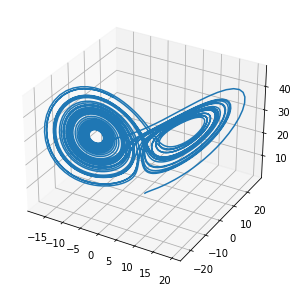

In [8]:
# dt
h = 0.01
# pre-allocate space and add initial conditions [x,y,z] = [1,1,1]
t_lor = np.arange(0, 40+h, h)
x_lor = np.zeros(len(t_lor))
x_lor[0] = 1

y_lor = np.zeros(len(t_lor))
y_lor[0] = 1

z_lor = np.zeros(len(t_lor))
z_lor[0] = 1

# Define Constants
sigma = 10
rho = 28
beta = 8.0/3.0

# Define function
def Lorenz_func(xyz):
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    
    f = sigma*(y-x)
    g = x*(rho-z)-y
    p = x*y-beta*z
    return np.stack([f,g,p])

# Time-stepping forloop
for i in range(1, len(t_lor)):
    xyz = np.stack([x_lor[i-1],y_lor[i-1],z_lor[i-1]])
    y = rk4_3D(Lorenz_func, xyz, h)
    x_lor[i] = y[0]
    y_lor[i] = y[1]
    z_lor[i] = y[2]

# Plot results
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.plot(x_lor, y_lor, z_lor)
plt.draw()
plt.show()
    

Since our RK-4 implementation appears to work, we remove 1-Dimension from the RK-4 implementation, to make it suitable for our system. We treat it as a 2-Dimensional system, with dimensions [u,b].

In [9]:
def rk4_2D(f, y0, dt):
    # Unpack input
    y0_0 = y0[0]
    y0_1 = y0[1]
    # First function evaluation
    ystar_1 = f(y0)
    # Unpack
    k1 = ystar_1[0]
    l1 = ystar_1[1]
    # Update input
    y1 = np.stack([y0_0 + k1*dt/2, y0_1 + l1*dt/2])
    
    # Second function evaluation
    ystar_2 = f(y1)
    # Unpack
    k2 = ystar_2[0]
    l2 = ystar_2[1]
    # Update input
    y2 = np.stack([y0_0 + k2*dt/2, y0_1 + l2*dt/2])

    # Third function evaluation
    ystar_3 = f(y2)
    # Unpack
    k3 = ystar_3[0]
    l3 = ystar_3[1]
    # Update input
    y3 = np.stack([y0_0 + k3*dt, y0_1 + l3*dt])
    
    # Fourth function evaluation
    ystar_4 = f(y3)
    # Unpack
    k4 = ystar_4[0]
    l4 = ystar_4[1]
    # Final update - this is similar to the stacks before, just done in 2 steps to make it more readable.
    yt_next_0 = y0_0 + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    yt_next_1 = y0_1 + (l1 + 2*l2 + 2*l3 + l4)*dt/6
    # Return stack
    return np.stack([yt_next_0, yt_next_1])


### Putting it all together
We can now use this to try and time-step the PDE functions from earlier. If we let S = 0, we arrive at an uncoupled diffusion system, which should be easier to solve. 

The PDE funtion defined earlier uses our Chebyshev differential Matrix, that we tested earlier, so that the spatial derivatives should behave correctly.

Following Fournier 2007, we will use the parameters:

$\Delta t = \text{2e-3}$

And time-step the model forward in time untill T=0.2

In [10]:
# Define S and Pm
S = 0
Pm = 1e-3

# Define time step and final Time
k = 2e-3
T = 0.2
# Resulting number of time-steps
T_dim = int(T/k)

# Spatial resolution
N = 100

# Chebychev for u and b. 1 gathered should be fine since we use constant N but.. better safe than sorry for now
Du, xu = cheb(N)
D2u = np.linalg.matrix_power(Du, 2)

Db, xb = cheb(N)
D2b = np.linalg.matrix_power(Db, 2)

# Pre allocate time-vector and spatial matrices.
# Time vector is just to keep track of our time step for later plotting.
t = np.zeros(T_dim)
u = np.zeros((T_dim, N+1))
b = np.zeros((T_dim, N+1))

# Define the true initial sate
u0 = np.sin(np.pi*xu.squeeze()) + (2/5)*np.sin(5*np.pi*xu.squeeze())
b0 = np.cos(np.pi*xb.squeeze()) + 2*np.sin(np.pi*(xb.squeeze() + 1)/4)

# Include true initial step as the first entrance in pre-allocated u and b matrices
u[0] = u0
b[0] = b0

# Time-step the system
for i in range(1, T_dim-1):
    # Stack u and b vector
    ub = np.stack([u[i-1], b[i-1]])
    # Run 2-dimensional RK-4
    dt = rk4_2D(PDE, ub, k)
    # Unpack and assign
    u[i] = dt[0]
    b[i] = dt[1]
    # Add 1-step to the time
    t[i] = t[i-1]+k
    


/home/rcj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in matmul
  # This is added back by InteractiveShellApp.init_path()
/home/rcj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in matmul
  # Remove the CWD from sys.path while we load stuff.
/home/rcj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/home/rcj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/home/rcj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply


We get an overflow errror here, which is due to the fact that the boundaries explode. To investigate, we'll include figures of time steps 0 (t = 0.00s), 5 (t = 0.01s), and 10 (t = 0.02s) below. This is for the simple uncoupled diffusion example, with S = 0. If we let S = 1, like Fournier 2007 does, this problem becomes even more pronounced. To see this, simply let S = 1 at the start of the cell above, and probably change variable timePlot to 1 to see the first 3 time steps. We always plot timesteps: 0, timeplot, and timeplotx2, which means that for timePlot = 1, we get time steps; 0, 1 and 2. Likewise for timePlot = 5, we get steps 0, 5 and 10. The step and equivalent time is displayed in the title of the plots.

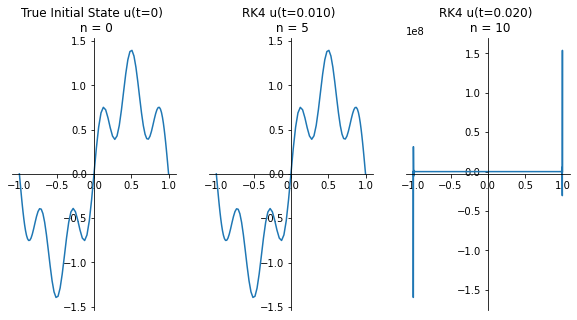

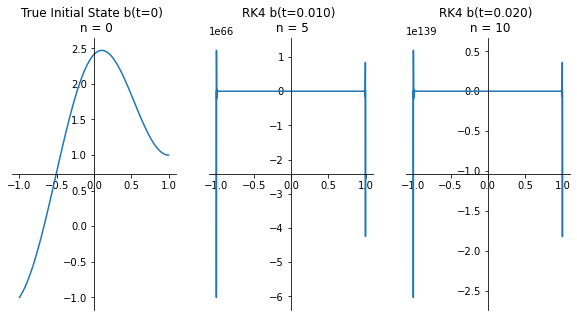

In [11]:
# Plot time steps 0 (n=0), 0.01 (n=5), and 0.02(n=10)
timePlot = 5
# Plot u
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.plot(xplot, u0)
ax1.set_title('True Initial State u(t=0) \n n = 0')
CreateCrossAxis(ax1)
ax2.plot(xplot, u[timePlot])
ax2.set_title('RK4 u(t=%0.3f) \n n = %i' %(t[timePlot], int(timePlot)))
CreateCrossAxis(ax2)
ax3.plot(xplot, u[timePlot*2])
ax3.set_title('RK4 u(t=%0.3f) \n n = %i' %(t[2*timePlot], int(2*timePlot)))
CreateCrossAxis(ax3)
plt.show()

# Plot b
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.plot(xplot, b0, '-')
ax1.set_title('True Initial State b(t=0) \n n = 0')
CreateCrossAxis(ax1)
ax2.plot(xplot, b[timePlot])
ax2.set_title('RK4 b(t=%0.3f) \n n = %i' %((t[timePlot]), int(timePlot)))
CreateCrossAxis(ax2)
ax3.plot(xplot, b[timePlot*2])
ax3.set_title('RK4 b(t=%.3f) \n n = %i' %(t[2*timePlot], int(2*timePlot)))
CreateCrossAxis(ax3)
plt.show()